In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler


sns.set(rc={'figure.figsize':(10,5)})
sns.set_theme(style="whitegrid")

In [2]:
df = pd.read_csv("data/genres_v2.csv", low_memory=False)
print(df.columns)
df.head()

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature', 'genre', 'song_name', 'Unnamed: 0', 'title'],
      dtype='object')


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,id,uri,track_href,analysis_url,duration_ms,time_signature,genre,song_name,Unnamed: 0,title
0,0.831,0.814,2,-7.364,1,0.4200,0.0598,0.013400,0.0556,0.3890,...,2Vc6NJ9PW9gD9q343XFRKx,spotify:track:2Vc6NJ9PW9gD9q343XFRKx,https://api.spotify.com/v1/tracks/2Vc6NJ9PW9gD...,https://api.spotify.com/v1/audio-analysis/2Vc6...,124539,4,Dark Trap,Mercury: Retrograde,NaN,NaN
1,0.719,0.493,8,-7.230,1,0.0794,0.4010,0.000000,0.1180,0.1240,...,7pgJBLVz5VmnL7uGHmRj6p,spotify:track:7pgJBLVz5VmnL7uGHmRj6p,https://api.spotify.com/v1/tracks/7pgJBLVz5Vmn...,https://api.spotify.com/v1/audio-analysis/7pgJ...,224427,4,Dark Trap,Pathology,NaN,NaN
2,0.850,0.893,5,-4.783,1,0.0623,0.0138,0.000004,0.3720,0.0391,...,0vSWgAlfpye0WCGeNmuNhy,spotify:track:0vSWgAlfpye0WCGeNmuNhy,https://api.spotify.com/v1/tracks/0vSWgAlfpye0...,https://api.spotify.com/v1/audio-analysis/0vSW...,98821,4,Dark Trap,Symbiote,NaN,NaN
3,0.476,0.781,0,-4.710,1,0.1030,0.0237,0.000000,0.1140,0.1750,...,0VSXnJqQkwuH2ei1nOQ1nu,spotify:track:0VSXnJqQkwuH2ei1nOQ1nu,https://api.spotify.com/v1/tracks/0VSXnJqQkwuH...,https://api.spotify.com/v1/audio-analysis/0VSX...,123661,3,Dark Trap,ProductOfDrugs (Prod. The Virus and Antidote),NaN,NaN
4,0.798,0.624,2,-7.668,1,0.2930,0.2170,0.000000,0.1660,0.5910,...,4jCeguq9rMTlbMmPHuO7S3,spotify:track:4jCeguq9rMTlbMmPHuO7S3,https://api.spotify.com/v1/tracks/4jCeguq9rMTl...,https://api.spotify.com/v1/audio-analysis/4jCe...,123298,4,Dark Trap,Venom,NaN,NaN


In [3]:
df['duration_ms'].value_counts()

192000    104
240000     87
224000     65
211200     56
230400     56
         ... 
177607      1
229200      1
194038      1
206016      1
162161      1
Name: duration_ms, Length: 26261, dtype: int64

Retirando as columnas que não serão necessárias para as nossas análises

In [4]:
df.drop(['type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms', 'time_signature', 'song_name', 'Unnamed: 0', 'title'], axis=1, inplace=True)
df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
0,0.831,0.814,2,-7.364,1,0.4200,0.0598,0.013400,0.0556,0.3890,156.985,Dark Trap
1,0.719,0.493,8,-7.230,1,0.0794,0.4010,0.000000,0.1180,0.1240,115.080,Dark Trap
2,0.850,0.893,5,-4.783,1,0.0623,0.0138,0.000004,0.3720,0.0391,218.050,Dark Trap
3,0.476,0.781,0,-4.710,1,0.1030,0.0237,0.000000,0.1140,0.1750,186.948,Dark Trap
4,0.798,0.624,2,-7.668,1,0.2930,0.2170,0.000000,0.1660,0.5910,147.988,Dark Trap


Apenas para contexo, uma explicação melhor de cada uma dessas features pode ser encontrada [aqui](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features).  

#### Procurando e Tratando Dados Inválidos

Valores nulos:

In [5]:
df.isnull().sum().sort_values(ascending=False)

danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
genre               0
dtype: int64

Valores divergentes do esperado pela documentação:

In [6]:
count = df.shape[0]
df.drop(df[(df['danceability'] > 1) | (df['danceability'] < 0)].index, inplace=True)
print("Dropped by danceability: ", count - df.shape[0])

Dropped by danceability:  0


In [7]:
count = df.shape[0]
df.drop(df[(df['energy'] > 1) | (df['energy'] < 0)].index, inplace=True)
print("Dropped by energy: ", count - df.shape[0])

Dropped by energy:  0


In [8]:
count = df.shape[0]
df.drop(df[(df['key'] > 11) | (df['key'] < -1)].index, inplace=True)
print("Dropped by key: ", count - df.shape[0])

Dropped by key:  0


In [9]:
count = df.shape[0]
df.drop(df[(df['loudness'] > 0) | (df['loudness'] < -60)].index, inplace=True)
print("Dropped by loudness: ", count - df.shape[0])

Dropped by loudness:  210


In [10]:
count = df.shape[0]
df.drop(df[(df['mode'] != 1) & (df['mode'] != 0)].index, inplace=True)
print("Dropped by mode: ", count - df.shape[0])

Dropped by mode:  0


In [11]:
count = df.shape[0]
df.drop(df[(df['speechiness'] > 1) | (df['speechiness'] < 0)].index, inplace=True)
print("Dropped by speechiness: ", count - df.shape[0])

Dropped by speechiness:  0


In [12]:
count = df.shape[0]
df.drop(df[(df['acousticness'] > 1) | (df['acousticness'] < 0)].index, inplace=True)
print("Dropped by acousticness: ", count - df.shape[0])

Dropped by acousticness:  0


In [13]:
count = df.shape[0]
df.drop(df[(df['instrumentalness'] > 1) | (df['instrumentalness'] < 0)].index, inplace=True)
print("Dropped by instrumentalness: ", count - df.shape[0])

Dropped by instrumentalness:  0


In [14]:
count = df.shape[0]
df.drop(df[(df['liveness'] > 1) | (df['liveness'] < 0)].index, inplace=True)
print("Dropped by liveness: ", count - df.shape[0])

Dropped by liveness:  0


In [15]:
count = df.shape[0]
df.drop(df[(df['valence'] > 1) | (df['valence'] < 0)].index, inplace=True)
print("Dropped by valence: ", count - df.shape[0])

Dropped by valence:  0


#### Análise Inicial dos Dados

Numero de dados por gênero:

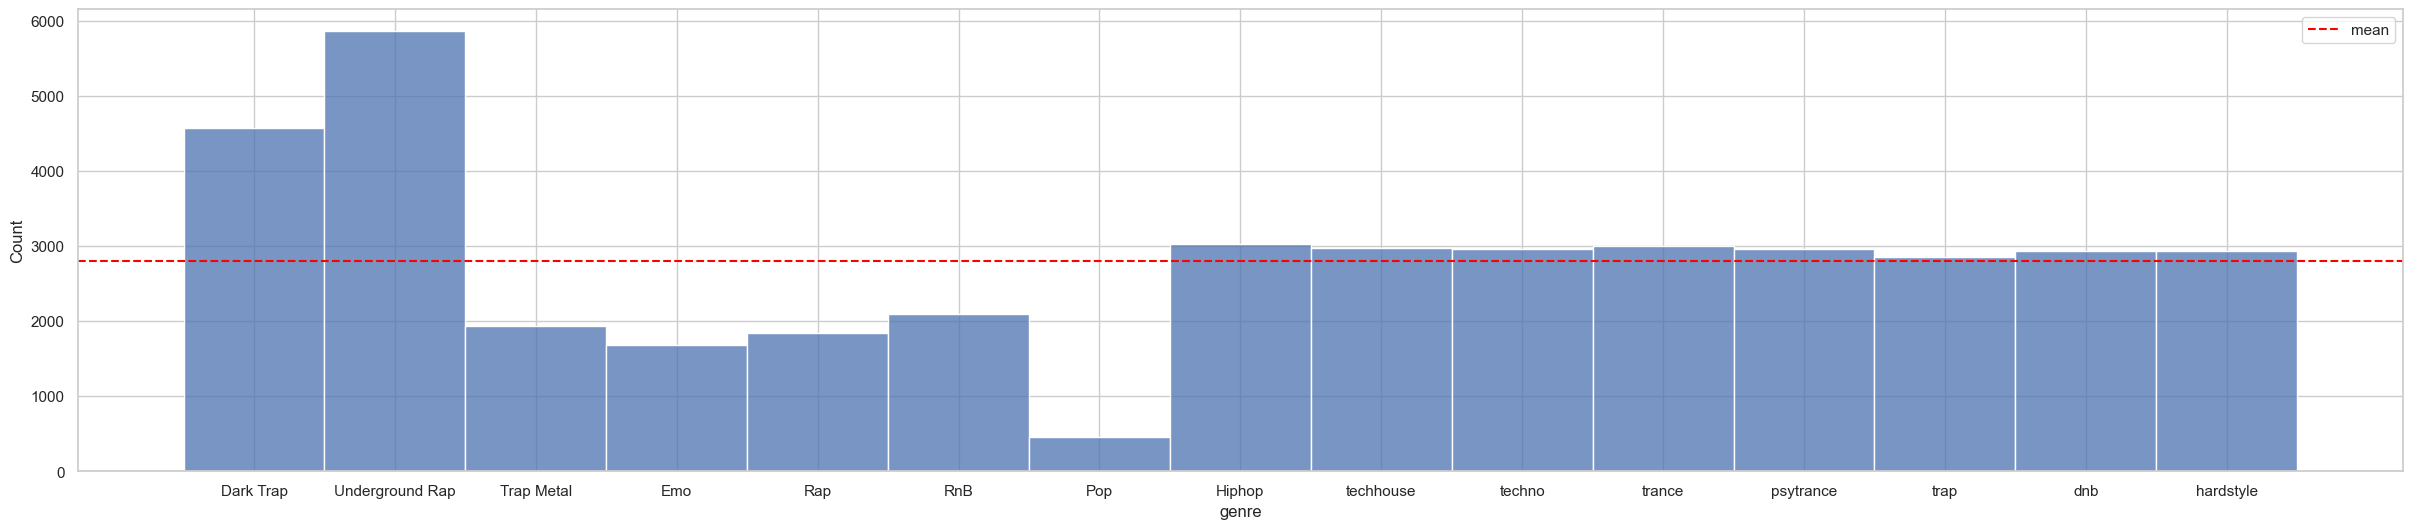

In [16]:
mean_count = df.groupby('genre').count().mean()[0]

f, ax = plt.subplots(1, 1, figsize=(30, 6))
sns.histplot(df, x='genre', ax=ax)
ax.axhline(mean_count, linestyle='dashed', label='mean', color='red')
ax.legend()

Como podemos ver, o dataset está bem desbalanceado. Para balancear vamos fazer duas coisas:
* Retirar o genero 'Pop', já que o mesmo possui poucos dados quanto comparado ao resto.
* Diminuir o número de músicas do DarkTrap e Undergroup Rap para o valor médio de músicas por gênero.

In [17]:
df.drop(df[df['genre'] == 'Pop' ].index, inplace=True)

dt_count = df[df['genre'] == 'Dark Trap'].shape[0]
df.drop(df[df['genre'] == 'Dark Trap'].sample(int(dt_count - mean_count)).index, inplace=True)

ur_count = df[df['genre'] == 'Underground Rap'].shape[0]
df.drop(df[df['genre'] == 'Underground Rap'].sample(int(ur_count - mean_count)).index, inplace=True)

Desse modo, teremos:

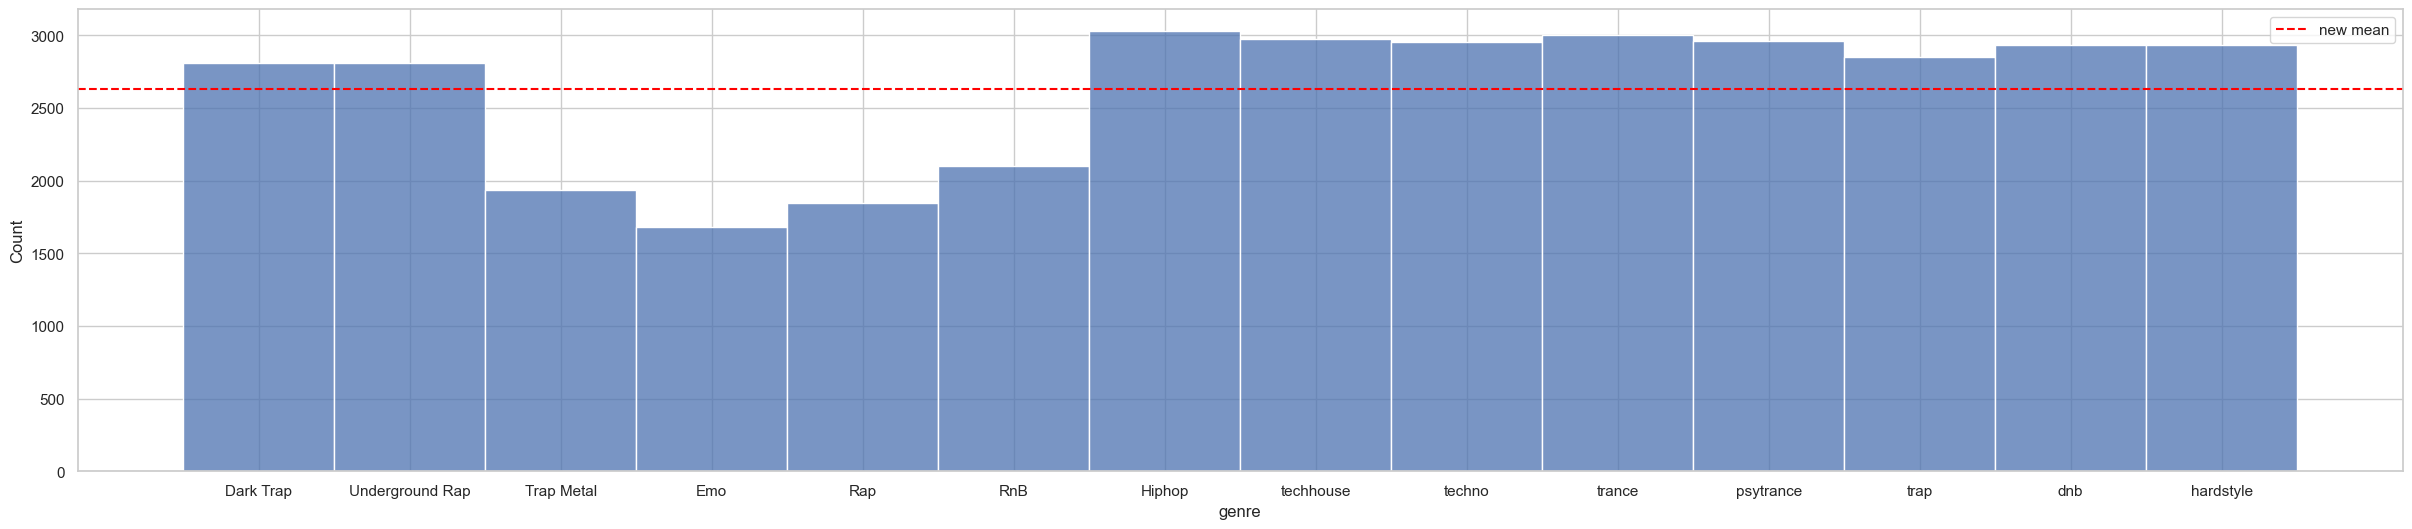

In [18]:
mean_count = df.groupby('genre').count().mean()[0]

f, ax = plt.subplots(1, 1, figsize=(30, 6))
sns.histplot(df, x='genre', ax=ax)
ax.axhline(mean_count, linestyle='dashed', label='new mean', color='red')
ax.legend()

Verificando a correlação entre as variáveis que utilizaremos para determinar o gênero:

C:\Users\seuto\AppData\Local\Temp\ipykernel_3480\1562033469.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


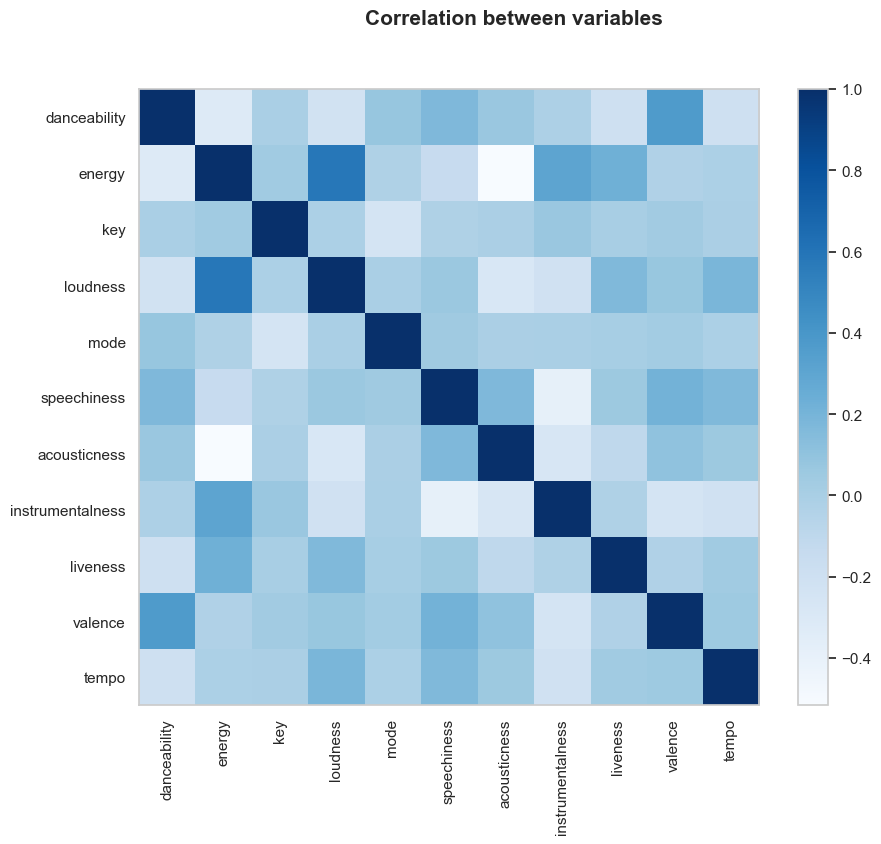

In [19]:
corr = df.corr()

plt.figure(figsize=(10, 8))
plt.imshow(corr, cmap='Blues', interpolation='none', aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation='vertical')
plt.yticks(range(len(corr)), corr.columns);
plt.suptitle('Correlation between variables', fontsize=15, fontweight='bold')
plt.grid(False)
plt.show()

Com isso podemos concluir que as variaveis que utilizaremos para determinar o gênero não possuem muita correlação entre si.

#### Normalizando os dados

In [20]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

scaler = StandardScaler()
X = scaler.fit_transform(X)

#### Análise e Redução da Dimensionalidade

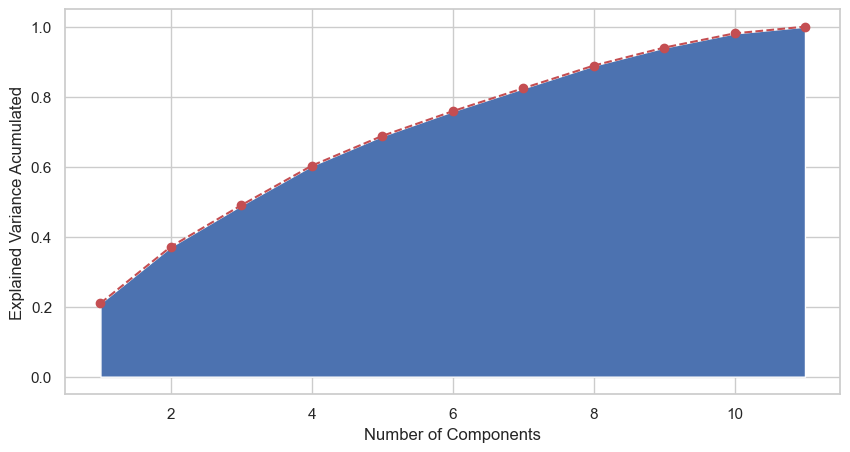

In [24]:
pca = PCA()
pca.fit(X)

exp_var_cumul = {   'Number of Components': range(1, X.shape[1] + 1),
                    'Explained Variance': np.cumsum(pca.explained_variance_ratio_)
                }


f, ax = plt.subplots(1, 1)

plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Acumulated')

ax.fill_between(exp_var_cumul['Number of Components'], exp_var_cumul['Explained Variance'])
ax.plot(exp_var_cumul['Number of Components'], exp_var_cumul['Explained Variance'], 'ro--')

Utilizando o pca para visualizar a classificação com 2 componentes


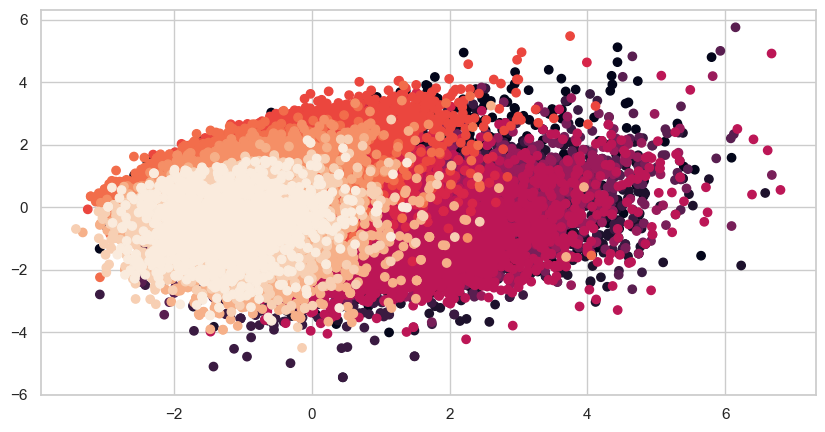

In [25]:
pca = PCA(n_components=2)
Xt = pca.fit_transform(X)


# Adicionando uma columna novo onde as classes se tornam numéricas
df['num_genre'] = 0
uniq_genres = df['genre'].unique()
i = 0
for genre in uniq_genres:
    df['num_genre'] = np.where(df["genre"] == genre, i, df['num_genre'])
    i += 1

plt.scatter(Xt[:,0], Xt[:,1], c=df['num_genre'], alpha = 1)

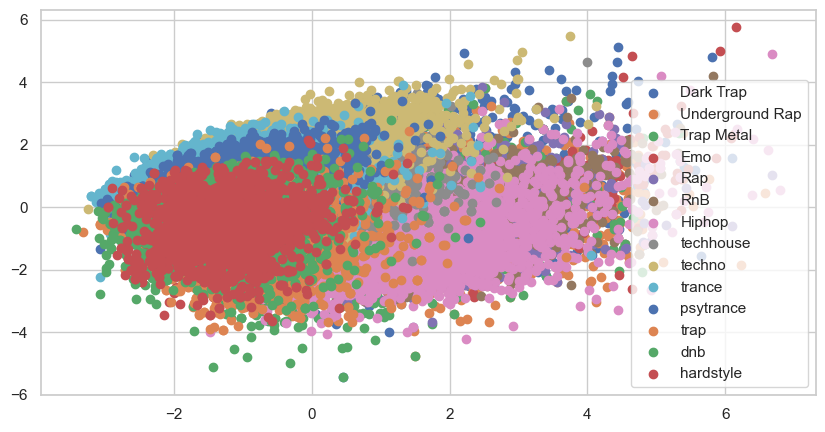

In [26]:
for label in uniq_genres:
    plt.scatter(Xt[y==label, 0], Xt[y==label, 1], label=label)

plt.legend()
plt.show()

In [23]:
tsne = TSNE(n_components=2)
z = tsne.fit_transform(X)

[Text(0.5, 1.0, 'T-SNE Projection')]

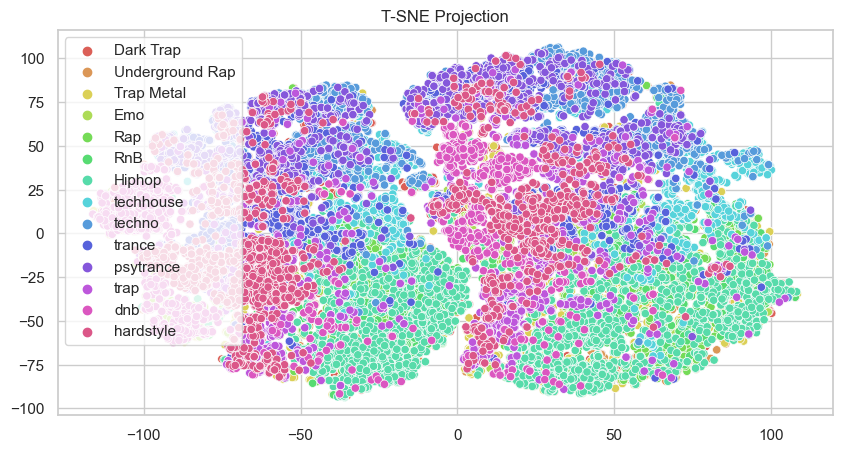

In [24]:
sns.scatterplot(x=z[:, 0], y=z[:, 1], hue=df.genre.tolist(),
                palette=sns.color_palette("hls", 14)).set(title="T-SNE Projection") 

In [34]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y)

In [35]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
y_train = enc.fit_transform(y_train.to_numpy().reshape(-1, 1))
y_test = enc.fit_transform(y_test.to_numpy().reshape(-1, 1))

In [23]:
parameters = {
    'max_depth': range (2, 5, 1),
    'n_estimators': range(60, 140, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [24]:
from xgboost import XGBClassifier

model = XGBClassifier(objective= 'binary:logistic', nthread=4)

In [25]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring = 'roc_auc', n_jobs = 10, cv = 10, verbose=10)

In [26]:
grid_search.fit(x_train, y_train.toarray())

Fitting 10 folds for each of 18 candidates, totalling 180 fits


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None, ...),
             n_jobs=10,
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': range(2, 5),
                         'n_estimators': range(60, 140, 40)},
             scoring='roc_auc', verbose=10)

In [28]:
best_model = grid_search.best_estimator_

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(best_model, x_train, y_train.toarray(), cv=5)
print("Acurácia média no Cross-Validation de treino: %.2f" % scores.mean())

In [36]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(best_model, x_test, y_test.toarray(), cv=5)
print("Acurácia média no Cross-Validation de teste: %.2f" % scores.mean())

Acurácia média no Cross-Validation: 0.53
